In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.signal import butter, lfilter
import datetime
from scipy.signal import iirfilter
%matplotlib inline

# Data Preprocessing

eeg channels

In [2]:
TP_L = 0
IF_L = 1
IF_R = 2
TP_R = 3
BASELINE = 4
channal_name = []
channal_name.append("TP_L")
channal_name.append("IF_L")
channal_name.append("IF_R")
channal_name.append("TP_R")
channal_name.append("BASELINE")

fs = 256

In [3]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegF2_df = pd.read_json('file:eegData_F2.json')
eegF3_df = pd.read_json('file:eegData_F3.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eegM2_df = pd.read_json('file:eegData_M2.json')
eegM3_df = pd.read_json('file:eegData_M3.json')
eegM4_df = pd.read_json('file:eegData_M4.json')
eegM5_df = pd.read_json('file:eegData_M5.json')

eventF1_df = pd.read_json('file:Event_F1.json')
eventF2_df = pd.read_json('file:Event_F2.json')
eventF3_df = pd.read_json('file:Event_F3.json')
eventM1_df = pd.read_json('file:Event_M1.json')
eventM2_df = pd.read_json('file:Event_M2.json')
eventM3_df = pd.read_json('file:Event_M3.json')
eventM4_df = pd.read_json('file:Event_M4.json')
eventM5_df = pd.read_json('file:Event_M5.json')

accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
eventM1_df = eventM1_df[['value', 'timestamp']]


Data from M1, M2 and F1 is from the experiment first iteration (see paper for explanation) 

In [4]:
participants_eeg = [eegF2_df, eegF3_df, eegM3_df, eegM4_df,eegM5_df]
participants_event = [eventF2_df,eventF3_df,eventM3_df,eventM4_df,eventM5_df]

The preprocessing was done accurding to the specifications of Krigolson Lab which pulished guidlines for using the muse headset. https://www.krigolsonlab.com/muse-analysis-matlab.html

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def notch_filter_60hz(data, fs, band_width=2, freq=60, order=3, filter_type='butter'):
    nyq  = fs/2.0
    low  = freq - band_width/2.0
    high = freq + band_width/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data


def clean_data(data, fs):
    mean = np.mean(data)
    data = data - mean
#    data = notch_filter_60hz(data,fs)
    data = butter_bandpass_filter(data, .5, 15, fs)
    return data

def discard_first_trial(eventlist):
    eventlist = np.delete(eventlist,0,1)
    return eventlist

In [6]:
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

Returnes:
* total length T of eeg data
* time vector starting from 0 to T with the length of the eeg data
* a 5 dimentional array of the cleaned eeg data

In [7]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(clean_data(np.array(eeg),fs))
#        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [8]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [9]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
#        normalizer = np.mean(np.abs(data[start:index]))
        for value in data[start:end]:
            epoch.append(value - baseline)
#        normalizer = np.mean(np.abs(data[start:index]))
#        for i in len(epoch):
#            epoch[i] = epoch[i]/normalizer
        if(np.var(epoch) > 200):
            continue
        epoch_list.append(epoch)
    return np.array(epoch_list)

### Process the timestamps of the stimuli 

In [10]:
time_vector_list = []
eeg_list = []
length_list = []
event_list = []

for i in np.arange(len(participants_eeg)):
#    print(i)
    time_vector,eeg,T = process_eeg_dataframe(participants_eeg[i])
    time_vector_list.append(time_vector)
    eeg_list.append(eeg)
    length_list.append(T)
    event = process_event_dataframe(participants_event[i],datetime_to_float(first_timestamp(participants_eeg[i])))
    event[1] = compute_EEG_indices(event[1], fs)
    event = discard_first_trial(event)
    event_list.append(event)

In [11]:
M1_offset = datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))
M2_offset = datetime_to_float(eventM2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM2_df))
M3_offset = datetime_to_float(eventM3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM3_df))
M4_offset = datetime_to_float(eventM4_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM4_df))
M5_offset = datetime_to_float(eventM5_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM5_df))
F1_offset = datetime_to_float(eventF1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF1_df))
F2_offset = datetime_to_float(eventF2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF2_df))
F3_offset = datetime_to_float(eventF3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF3_df))

print('M1 offset: ' + str(M1_offset))
print('M2 offset: ' + str(M2_offset))
print('M3 offset: ' + str(M3_offset))
print('M4 offset: ' + str(M4_offset))
print('M5 offset: ' + str(M5_offset))
print('F1 offset: ' + str(F1_offset))
print('F2 offset: ' + str(F2_offset))
print('F3 offset: ' + str(F3_offset))

target_offset = (M3_offset + M4_offset)/2
print('Target offset: ' + str(target_offset))

m3_offset_shift = target_offset - M3_offset
print('M3 offset shift: ' + str(m3_offset_shift))

m4_offset_shift = target_offset - M4_offset
print('M4 offset shift: ' + str(m4_offset_shift))

m3_index_shift = int(fs * m3_offset_shift)
m4_index_shift = int(fs * m4_offset_shift)

print(m3_index_shift)
print(m4_index_shift)

# note: fix indices for M3 and M4

M1 offset: 11.270625114440918
M2 offset: 11.25
M3 offset: -3165.8001251220703
M4 offset: 3174.6126248836517
M5 offset: 4.40625
F1 offset: 611.2706251144409
F2 offset: 4.40625
F3 offset: 4.453125
Target offset: 4.4062498807907104
M3 offset shift: 3170.206375002861
M4 offset shift: -3170.206375002861
811572
-811572


The offset is the difrence between the first eeg timestamp and the first trial timestamp.
Given that M3 and M4 offsets are approximately the same magnitude but in opposite directions, their difference was taken. This came out to almost exactly twice the offset for M5 and F2, who were the next participants following M3 and M4 (M4 was recorded directly after M3). Thus buy shifting the offsets for M3 and M4 by the same amount in opposite directions, they reach almost the exact final offset as the subjects recorded just following them. This seems too unlikely to be a coincidence, and is likely the result of some unknown error in the code, so it was deemed a reasonable adjustment to make.

# Explain why this is ok
M3 and M4 had their time stamps for the event stimuli adjusted. 

In [12]:
print(event_list[2][1])
event_list[2][1] = event_list[2][1] + m3_index_shift
print(event_list[2][1])

[-809316 -808176 -807048 -805908 -804780 -803652 -802512 -801384 -800244
 -799116 -797988 -796848 -795720 -794580 -793452 -792324 -791184 -790056
 -788916 -787788 -786660 -785520 -784392 -783252 -782124 -780996 -779856
 -778728 -777588 -776460 -775332 -774192 -773064 -771924 -770796 -769668
 -768528]
[2256 3396 4524 5664 6792 7920 9060 10188 11328 12456 13584 14724 15852
 16992 18120 19248 20388 21516 22656 23784 24912 26052 27180 28320 29448
 30576 31716 32844 33984 35112 36240 37380 38508 39648 40776 41904 43044]


In [13]:
print(event_list[3][1])
event_list[3][1] = event_list[3][1] + m4_index_shift
print(event_list[3][1])

[813828 814968 816096 817224 818364 819492 820632 821760 822888 824028
 825156 826296 827424 828552 829692 830820 831960 833088 834216 835356
 836484 837624 838752 839880 841020 842148 843288 844416 845544 846684
 847812 848952 850080 851208 852348 853476 854616]
[2256 3396 4524 5652 6792 7920 9060 10188 11316 12456 13584 14724 15852
 16980 18120 19248 20388 21516 22644 23784 24912 26052 27180 28308 29448
 30576 31716 32844 33972 35112 36240 37380 38508 39636 40776 41904 43044]


# Epoching and pre-stimulus vs post stimulus power spectra

In [14]:
len_pre = -.5
len_post = 1

In [15]:
cat_index = []
snake_index = []

for i in np.arange(len(eeg_list)):
    cat_index.append([])
    snake_index.append([])            

epochs_cat = [[],[],[],[],[]]
epochs_snake = [[],[],[],[],[]]


for participant in np.arange(len(eeg_list)):
    for i in np.arange(len(event_list[participant][0])):
        if(event_list[participant][0][i] < 12):
            cat_index[participant].append(event_list[participant][1][i])
        else:
            snake_index[participant].append(event_list[participant][1][i])


for participant in np.arange(len(eeg_list)):
    for channel in np.arange(5):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    
        
epochs_cat = np.array(epochs_cat)

epochs_snake = np.array(epochs_snake)


C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
for channel in np.arange(5):
    for participant in np.arange(len(eeg_list)):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    

C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:

print("shape of epochs_cat[TP_L] :    ", np.array(epochs_cat[TP_L]).shape)
print("shape of epochs_snake[TP_L]  : ", np.array(epochs_snake[TP_L]).shape)
print("mean of epochs_cat[TP_L] :     ", np.mean(epochs_cat[TP_L]))


shape of epochs_cat[TP_L] :     (158, 384)
shape of epochs_snake[TP_L]  :  (64, 384)
mean of epochs_cat[TP_L] :      -0.052059015472157494


In [18]:
cat_average = []
snake_average = []
for channel in np.arange(5):
#    print(np.array(epochs_cat[channel]).shape)
    cat_average.append(np.mean(epochs_cat[channel], axis=0))
    snake_average.append(np.mean(epochs_snake[channel], axis=0))

cat_average= np.array(cat_average)
snake_average= np.array(snake_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)

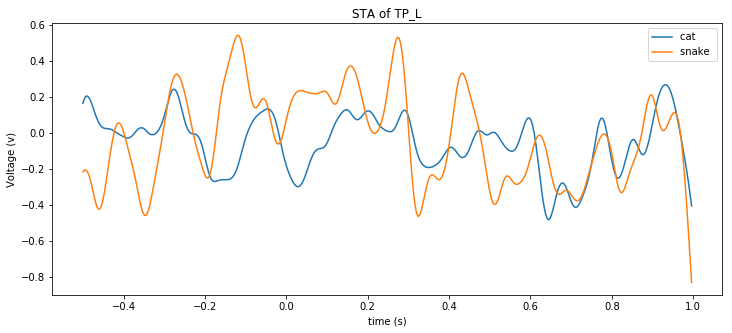

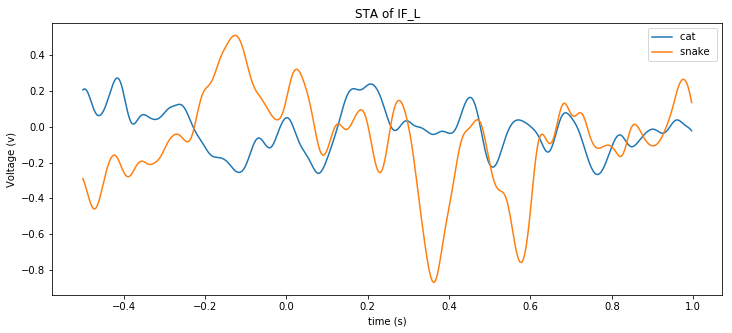

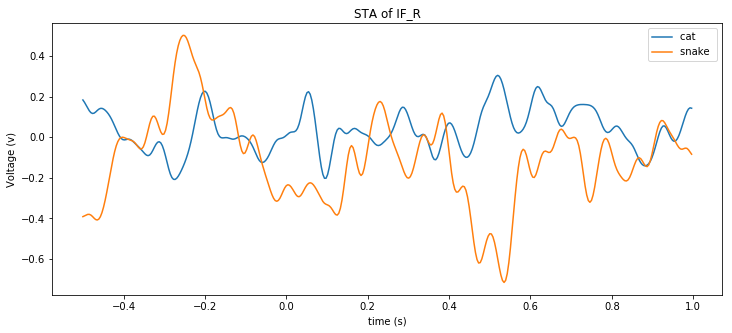

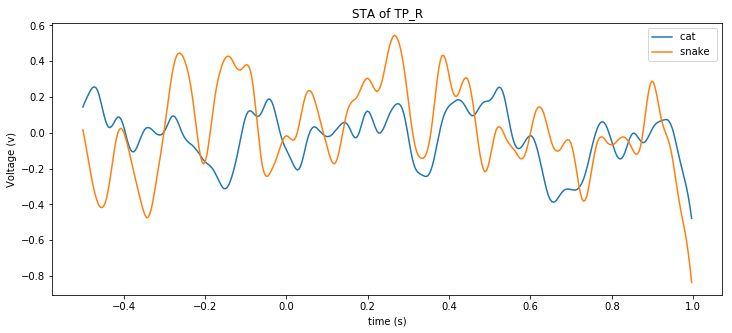

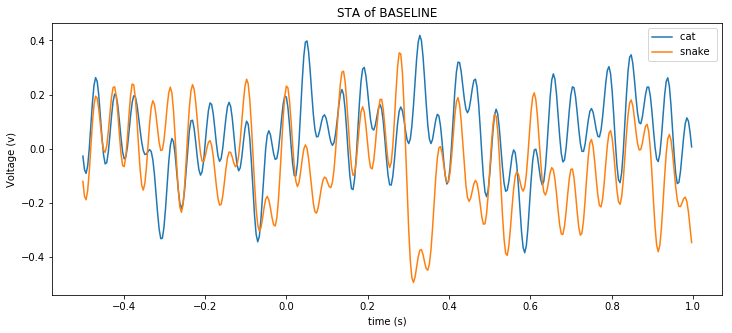

In [19]:
for i in range(0,len(channal_name)):
    # plot STA
    plt.figure(figsize=(12,5))
    plt.title("STA of " + channal_name[i])
    plt.plot(epoch_time, cat_average[i], '-', label = "cat ")
    plt.plot(epoch_time, snake_average[i], '-', label = "snake ")
    plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
    plt.legend()


In [20]:
#post-stimulus
cat_fft_post = [np.fft.fft(cat_average[i][int(-len_pre*fs):]) for i in range(0,5)]
snake_fft_post = [np.fft.fft(snake_average[i][int(-len_pre*fs):]) for i in range(0,5)]

cat_power_post = [np.abs(cat_fft_post[i])**2 for i in range(0,5)]
snake_power_post = [np.abs(snake_fft_post[i])**2 for i in range(0,5)]

fft_freqs_post = np.fft.fftfreq(np.array(cat_fft_post).shape[-1],1/fs)

#pre-stimulus
cat_fft_pre = [np.fft.fft(cat_average[i][:int(-len_pre*fs)]) for i in range(0,5)]
snake_fft_pre = [np.fft.fft(snake_average[i][:int(-len_pre*fs)]) for i in range(0,5)]

cat_power_pre = [np.abs(cat_fft_pre[i])**2 for i in range(0,5)]
snake_power_pre = [np.abs(snake_fft_pre[i])**2 for i in range(0,5)]

fft_freqs_pre = np.fft.fftfreq(np.array(cat_fft_pre).shape[-1],1/fs)

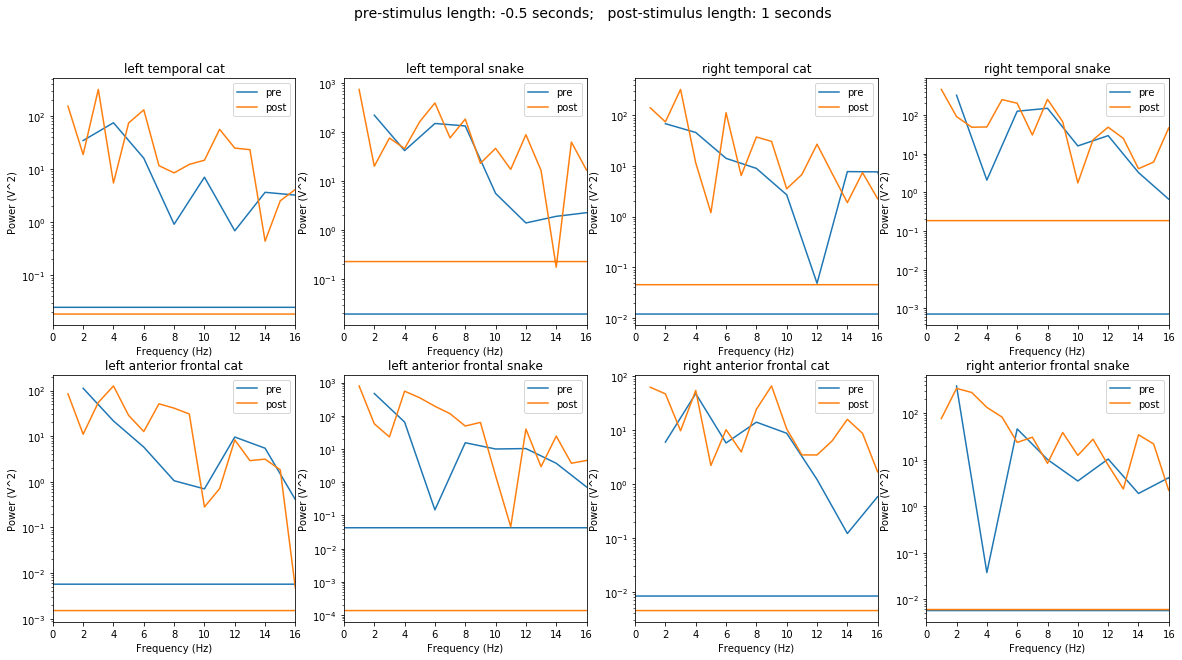

In [21]:
plt.figure(figsize=(20,10),)
plt.suptitle('pre-stimulus length: '+str(len_pre)+' seconds;   post-stimulus length: '+str(len_post)+' seconds', fontsize=14)
plt.subplot(2,4,1)
plt.plot(fft_freqs_pre[1:],cat_power_pre[0][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[0][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('left temporal cat')
plt.legend()

plt.subplot(2,4,2)
plt.plot(fft_freqs_pre[1:],snake_power_pre[0][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[0][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('left temporal snake')
plt.legend()


plt.subplot(2,4,3)
plt.plot(fft_freqs_pre[1:],cat_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('right temporal cat')
plt.legend()

plt.subplot(2,4,4)
plt.plot(fft_freqs_pre[1:],snake_power_pre[3][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[3][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('right temporal snake')
plt.legend()


plt.subplot(2,4,5)
plt.plot(fft_freqs_pre[1:],cat_power_pre[1][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[1][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('left anterior frontal cat')
plt.legend()

plt.subplot(2,4,6)
plt.plot(fft_freqs_pre[1:],snake_power_pre[1][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[1][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('left anterior frontal snake')
plt.legend()


plt.subplot(2,4,7)
plt.plot(fft_freqs_pre[1:],cat_power_pre[2][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],cat_power_post[2][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('right anterior frontal cat')
plt.legend()

plt.subplot(2,4,8)
plt.plot(fft_freqs_pre[1:],snake_power_pre[2][1:],'-', label='pre')
plt.plot(fft_freqs_post[1:],snake_power_post[2][1:],'-', label='post')
plt.yscale('log')
plt.xlim(0,16)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2)')
plt.title('right anterior frontal snake')
plt.legend()


## Correlation

In [22]:
from scipy import stats
def pearson (x,y):
    return stats.pearsonr(x, y)

In [23]:
for i in range(0,len(channal_name)): 
    print('The Pearson correlation is: '+ str(pearson(cat_average[i],snake_average[i]))+' in electrode '+str(i+1)+' '+ channal_name[i])

The Pearson correlation is: (0.2757360976361075, 3.96229679783118e-08) in electrode 1 TP_L
The Pearson correlation is: (-0.25606825317655957, 3.6456157048873564e-07) in electrode 2 IF_L
The Pearson correlation is: (-0.37225560287333, 4.566946079217202e-14) in electrode 3 IF_R
The Pearson correlation is: (0.19155248359578542, 0.00015908781965533588) in electrode 4 TP_R
The Pearson correlation is: (0.24613380967153717, 1.0458274940429628e-06) in electrode 5 BASELINE


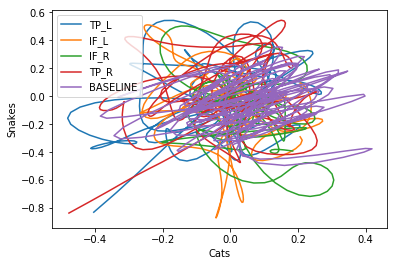

In [24]:
for i in range(0,len(channal_name)): 
    plt.plot(cat_average[i],snake_average[i], label=channal_name[i])
    plt.legend()
    plt.xlabel('Cats')
    plt.ylabel('Snakes')

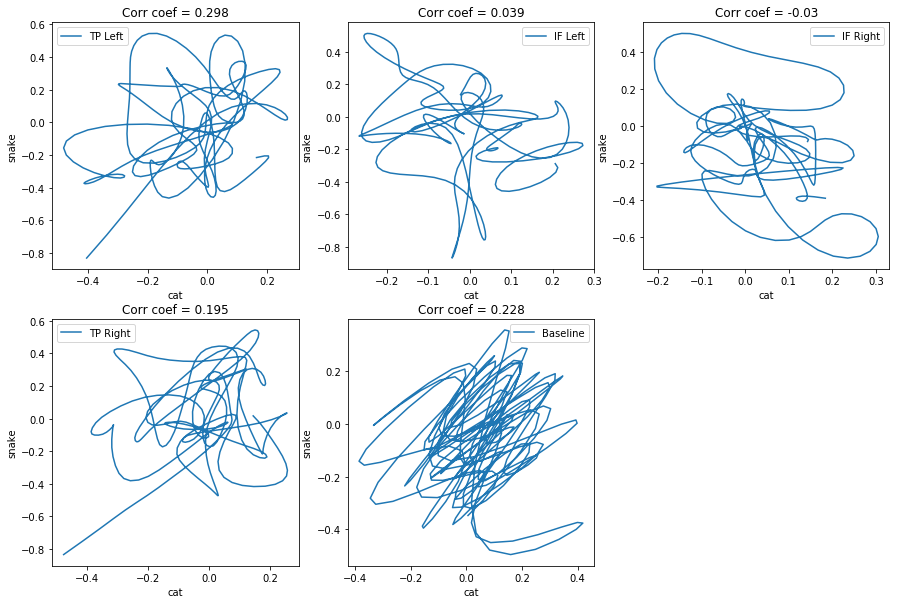

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.title('Corr coef = 0.298')
plt.plot(cat_average[0],snake_average[0],label='TP Left')
plt.xlabel('cat')
plt.ylabel('snake')
plt.legend()

plt.subplot(232)
plt.title('Corr coef = 0.039')
plt.plot(cat_average[1],snake_average[1],label='IF Left')
plt.xlabel('cat')
plt.ylabel('snake')
plt.legend()

plt.subplot(233)
plt.title('Corr coef = -0.03')
plt.plot(cat_average[2],snake_average[2],label='IF Right')
plt.xlabel('cat')
plt.ylabel('snake')
plt.legend()

plt.subplot(234)
plt.title('Corr coef = 0.195')
plt.plot(cat_average[3],snake_average[3],label='TP Right')
plt.xlabel('cat')
plt.ylabel('snake')
plt.legend()

plt.subplot(235)
plt.title('Corr coef = 0.228')
plt.plot(cat_average[4],snake_average[4],label='Baseline')
plt.xlabel('cat')
plt.ylabel('snake')
plt.legend()

(0.7553428492601184, 4.162245005526204e-72)
(-0.20401876767873098, 5.641161796314747e-05)
(-0.10947370660613555, 0.031977331184672074)
(0.7060984196986843, 3.1620968014339155e-59)
(0.15974913539397, 0.0016870765267223834)
(0.31238097617799687, 3.880921036500239e-10)


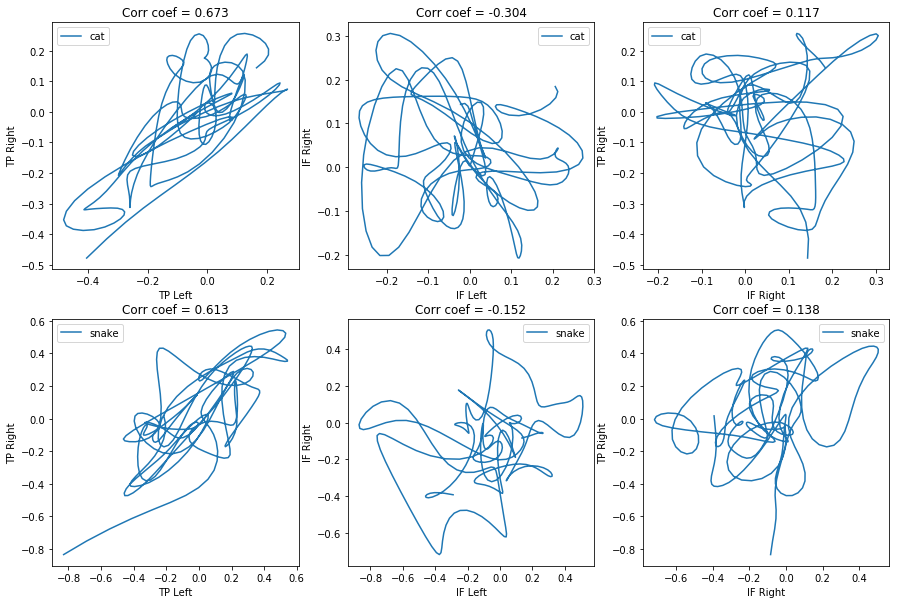

In [26]:
plt.figure(figsize=(15,10))
print(pearson(cat_average[0],cat_average[3]))
plt.subplot(231)
plt.title('Corr coef = 0.673')
plt.plot(cat_average[0],cat_average[3],label='cat')
plt.xlabel('TP Left')
plt.ylabel('TP Right')
plt.legend()

plt.subplot(232)
plt.title('Corr coef = -0.304')
print(pearson(cat_average[1],cat_average[2]))
plt.plot(cat_average[1],cat_average[2],label='cat')
plt.xlabel('IF Left')
plt.ylabel('IF Right')
plt.legend()

plt.subplot(233)
plt.title('Corr coef = 0.117')
print(pearson(cat_average[2],cat_average[3]))
plt.plot(cat_average[2],cat_average[3],label='cat')
plt.xlabel('IF Right')
plt.ylabel('TP Right')
plt.legend()

plt.subplot(234)
plt.title('Corr coef = 0.613')
print(pearson(snake_average[0],snake_average[3]))
plt.plot(snake_average[0],snake_average[3],label='snake')
plt.xlabel('TP Left')
plt.ylabel('TP Right')
plt.legend()

plt.subplot(235)
plt.title('Corr coef = -0.152')
print(pearson(snake_average[1],snake_average[2]))
plt.plot(snake_average[1],snake_average[2],label='snake')
plt.xlabel('IF Left')
plt.ylabel('IF Right')
plt.legend()

plt.subplot(236)
plt.title('Corr coef = 0.138')
print(pearson(snake_average[2],snake_average[3]))
plt.plot(snake_average[2],snake_average[3],label='snake')
plt.xlabel('IF Right')
plt.ylabel('TP Right')
plt.legend()

## Coherence

In [27]:
len_win = 2
len_overlap = 1

In [28]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

max freq =  2
257


(257, 170)

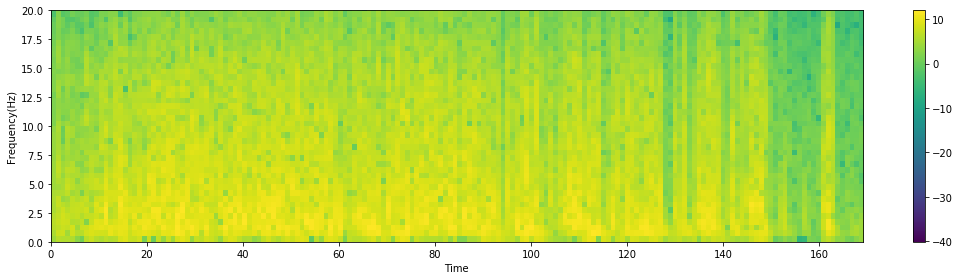

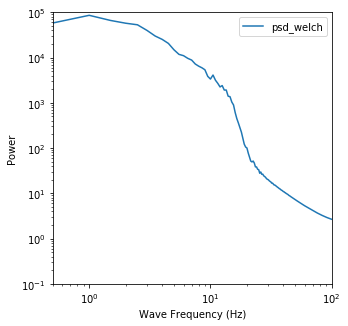

In [29]:
participant = 0
max_freq = 3
chan = TP_L
f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][chan], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)
spg = np.abs(stft)**2
# use plot_spectrogram
plot_spectrogram(np.log(spg), t_stft, f_stft, plot_db=False, freq_lims=[0,20])

# computing welch's spectrogram for you
f_welch, p_welch = signal.welch(np.array(eeg_list)[participant][chan],fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))
p_welch *= 0.5*len_win # again, undoing scipy's normalization
# plot the PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft, p_welch, '-', alpha=1, label='psd_welch')
print("max freq = ", np.argmax(p_welch))
max_freq =  np.argmax(p_welch)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1,100000])
plt.xlim([0.5,100])
plt.ylabel('Power')
plt.xlabel('Wave Frequency (Hz)');
print(len(stft))
stft.shape

We get the coherence for all freq for both the pre and post stimuli windows fo both cats and snakes. Windows whose car is > 200 are discarded to account for artefacts.

In [70]:
def get_coherence_all_freq( f_stft, t_stft, stft, participant,len_win, len_overlap   ):
    
    f_ind = np.arange(0,len(f_stft))
    cat_times = np.array(cat_index[participant] )/ fs
    cat_times = cat_times.astype(int)
    snake_time = np.array(snake_index[participant] )/ fs
    snake_time = snake_time.astype(int)

    normelised_sum = 0
    count = 0
    for trial_ind in cat_times - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()
 
        if(np.var(X_trial) > 200):
            continue
        X_trial /= np.abs(X_trial)
        count += 1
        normelised_sum += X_trial
    X_mean = normelised_sum / count
    coherence = np.abs(X_mean)
    coherence_cat_pre =coherence

    normelised_sum = 0
    count = 0
    for trial_ind in cat_times:
        X_trial = stft[f_ind, trial_ind].squeeze()

        if(np.var(X_trial) > 200):
            continue
        X_trial /= np.abs(X_trial)
        count += 1
        normelised_sum += X_trial
    X_mean = normelised_sum / count
    coherence = np.abs(X_mean)
    coherence_cat_post = coherence

    normelised_sum = 0
    count = 0
    for trial_ind in snake_time - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()

        if(np.var(X_trial) > 200):
            continue
        X_trial /= np.abs(X_trial)
        count += 1
        normelised_sum += X_trial

    X_mean = normelised_sum / count
    coherence = np.abs(X_mean)
    coherence_snake_pre = coherence
    
    normelised_sum = 0
    count = 0
    for trial_ind in snake_time:
        X_trial = stft[f_ind, trial_ind].squeeze()

        if(np.var(X_trial) > 200):
            continue
        X_trial /= np.abs(X_trial)
        count += 1
        normelised_sum += X_trial
    X_mean = normelised_sum / count
    coherence = np.abs(X_mean)
    coherence_snake_post = coherence
    
    return (coherence_cat_pre,coherence_cat_post,coherence_snake_pre, coherence_snake_post)


## Get coherence for each person and for each channal

In [71]:
coherence_cat_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_cat_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
psd = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]

for participant in np.arange(len(eeg_list)):
    for c in range(0,5):
        f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][c], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)
        spg = np.abs(stft)**2
        psd[participant][c] = np.mean(spg, axis=1) 
        cat_pre, snake_pre, cat_post, snake_post = get_coherence_all_freq(f_stft, t_stft, stft, participant,1,0.5)
        coherence_cat_pre[participant][c] = (cat_pre)
        coherence_snake_pre[participant][c] = (snake_pre)
        coherence_cat_post[participant][c] = (cat_post)
        coherence_snake_post[participant][c] = (snake_post)


In [72]:
coherence_cat_pre = np.array(coherence_cat_pre)
coherence_snake_pre = np.array(coherence_snake_pre)
coherence_cat_post = np.array(coherence_cat_post)
coherence_snake_post = np.array(coherence_snake_post)
psd = np.array(psd)
psd.shape


(5, 5, 257)

In [73]:
coherence_cat_pre = np.mean(coherence_cat_pre, axis =0)
coherence_snake_pre = np.mean(coherence_snake_pre, axis =0)
coherence_cat_post = np.mean(coherence_cat_post, axis =0)
coherence_snake_post = np.mean(coherence_snake_post, axis =0)
psd = np.mean(psd, axis =0)

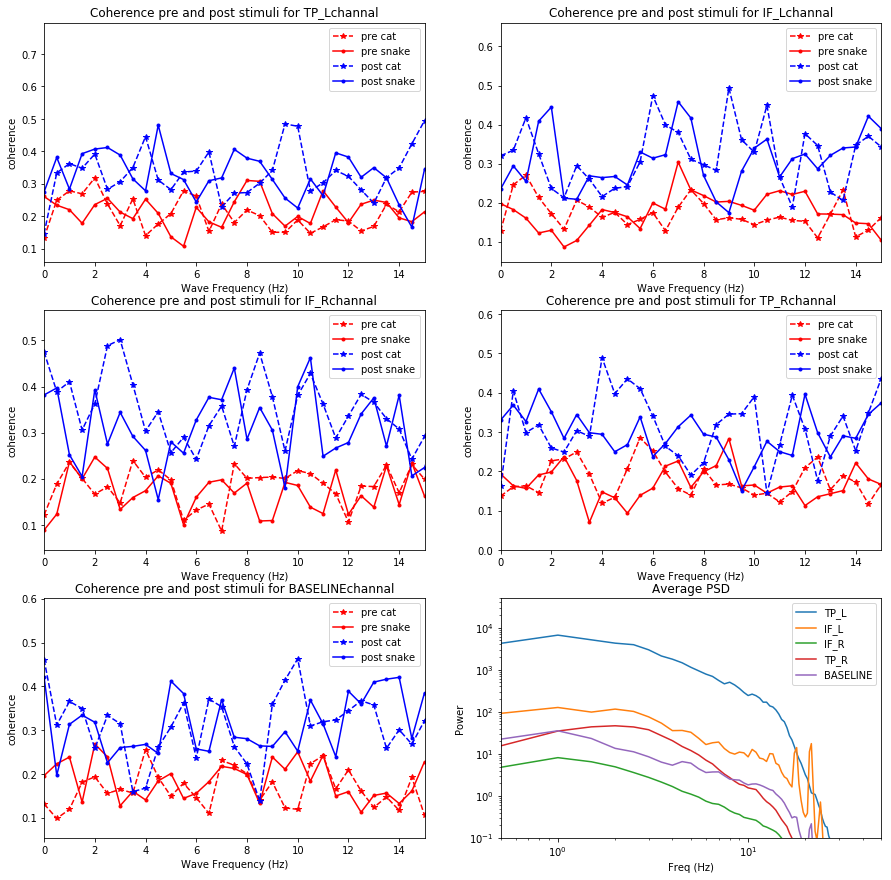

In [82]:
plt.figure(figsize=(15,15))

for i in range(0,len(channal_name)):

    #psd[i] /= np.linalg.norm(psd[i])
    plt.subplot(3,2,i+1)
    plt.title("Coherence pre and post stimuli for " + channal_name[i] + "channal")
    
    plt.plot(f_stft, coherence_cat_pre[i], 'r*--', alpha=1, label='pre cat')
    plt.plot(f_stft, coherence_snake_pre[i], 'r.-', alpha=1, label='pre snake')
    plt.plot(f_stft, coherence_cat_post[i], 'b*--', alpha=1, label='post cat')
    plt.plot(f_stft, coherence_snake_post[i], 'b.-', alpha=1, label='post snake')


    plt.legend()
    plt.xlim([0,15]);
    #plt.ylim([-1,1]);
    plt.ylabel('coherence')
    plt.xlabel('Wave Frequency (Hz)');

plt.subplot(3,2,6)
plt.title("Average PSD")

plt.plot(f_stft, psd[0], alpha=1, label=channal_name[0])
plt.plot(f_stft, psd[1], alpha=1, label=channal_name[1])
plt.plot(f_stft, psd[2], alpha=1, label=channal_name[2])
plt.plot(f_stft, psd[3], alpha=1, label=channal_name[3])
plt.plot(f_stft, psd[4], alpha=1, label=channal_name[4])
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1,50000])
plt.xlim([0.5,50])

plt.legend()
#plt.ylim([-1,1]);
plt.ylabel('Power')
plt.xlabel('Freq (Hz)');



In [79]:
print("mean elevation in coherence")
print("channel     cat       snake")
print(channal_name[0] + " :     ", np.round(np.mean(coherence_cat_post[0]) - np.mean(coherence_cat_pre[0]), 3),"   ", np.round(np.mean(coherence_snake_post[0]) - np.mean(coherence_cat_pre[0]), 3))
print(channal_name[1] + " :    ", np.round(np.mean(coherence_cat_post[1]) - np.mean(coherence_cat_pre[1]), 3),"    ",np.round(np.mean(coherence_snake_post[1]) - np.mean(coherence_cat_pre[1]), 3))
print(channal_name[2] + " :     ", np.round(np.mean(coherence_cat_post[2]) - np.mean(coherence_cat_pre[2]), 3),"   ",np.round(np.mean(coherence_snake_post[2]) - np.mean(coherence_cat_pre[2]), 3))
print(channal_name[3] + " :     ", np.round(np.mean(coherence_cat_post[3]) - np.mean(coherence_cat_pre[3]), 3),"   ",np.round(np.mean(coherence_snake_post[3]) - np.mean(coherence_cat_pre[3]), 3))
print(channal_name[4] + " : ", np.round(np.mean(coherence_cat_post[4]) - np.mean(coherence_cat_pre[4]), 3),"    ",np.round(np.mean(coherence_snake_post[4]) - np.mean(coherence_cat_pre[4]), 3))


mean elevation in coherence
channel     cat       snake
TP_L :      0.143     0.1
IF_L :     0.108      0.123
IF_R :      0.141     0.161
TP_R :      0.106     0.117
BASELINE :  0.11      0.094
